In [94]:
import os,sys
import pandas as pd
import numpy as np
from sklearn import metrics
import networkx as nx
from scipy import stats
from sklearn import cluster
from sklearn import neighbors
from brewer2mpl import qualitative
import  community
import geopandas as gpd

sys.path.append('../code')
import pop_graph as popg

# graphics stuff
%config InlineBackend.figure_format = 'png'
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,10
# rcParams['figure.dpi'] = 300

In [2]:
# load data
dat = pd.read_csv('../data/demo/nyc_example_coney.csv', index_col = 0)
dat.head()

,in_married_fam_or_couple_hh,in_other_fam_hh,in_nfam_hh,living_alone,in_group_quarters,age_05_under,age_06_17,age_18_24,age_25_34,age_35_64,...,somewhat_above_poverty,well_above_poverty,White_alone,Black_or_African_American_alone,Asian_alone,Hispanic_or_Latino,foreign_born,lang_not_eng_at_home,not_a_US_citizen,limited_english_proficient
36047032600,1,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,1,1,0,1
36047032600,1,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,1,1,0,1
36047032600,1,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,1,1,0,1
36047032600,1,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,1,1,0,1
36047032600,1,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,1,1,0,1


In [3]:
# target locations
locs = pd.unique(dat.index)

In [4]:
# generate tract-level co-occurrence matrices/population graphs (takes a moment)
loc_g = popg.build_pop_graphs(dat = dat, locs = locs, verbose = False)

/home/joe/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


## Single Location

In [5]:
# Census Tract 326 in Coney Island
target_loc = locs[0]
target_loc

36047032600

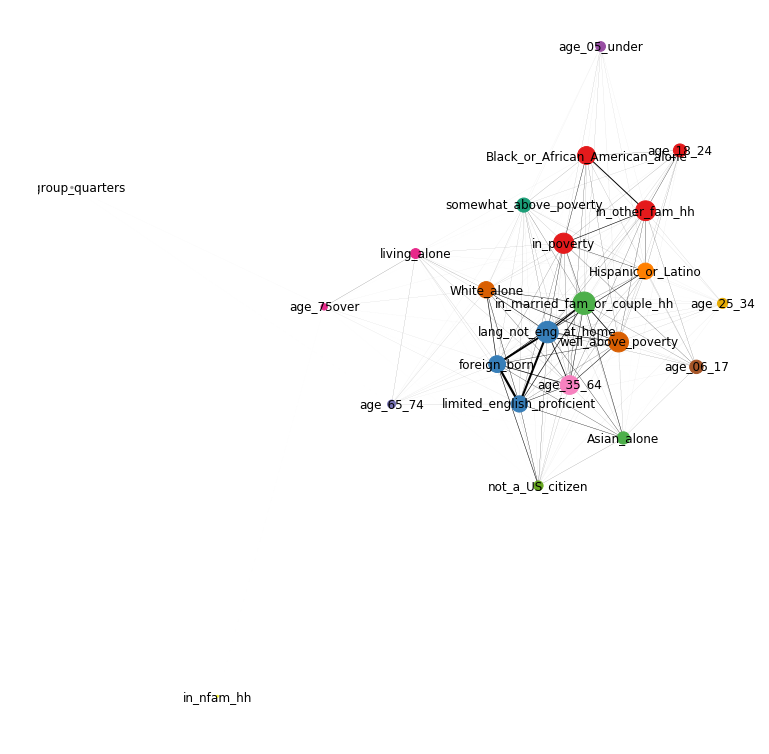

In [33]:
np.random.seed(303)
popg.drawPopGraph(G = loc_g[target_loc][0], part = loc_g[target_loc][1], tcl = dat[dat.index == target_loc])

In [7]:
t_part = loc_g[target_loc][1]
t_part

{'Asian_alone': 2,
 'Black_or_African_American_alone': 0,
 'Hispanic_or_Latino': 4,
 'White_alone': 10,
 'age_05_under': 3,
 'age_06_17': 6,
 'age_18_24': 0,
 'age_25_34': 14,
 'age_35_64': 7,
 'age_65_74': 11,
 'age_75over': 12,
 'foreign_born': 1,
 'in_group_quarters': 8,
 'in_married_fam_or_couple_hh': 2,
 'in_nfam_hh': 5,
 'in_other_fam_hh': 0,
 'in_poverty': 0,
 'lang_not_eng_at_home': 1,
 'limited_english_proficient': 1,
 'living_alone': 12,
 'not_a_US_citizen': 13,
 'somewhat_above_poverty': 9,
 'well_above_poverty': 10}

In [8]:
t_traits = dat[dat.index==target_loc]

### Investigating Graph Prototypes

In [9]:
cl = 1
tcl = [i for i in t_part.keys() if t_part[i]==cl]

In [10]:
tcl

['foreign_born', 'lang_not_eng_at_home', 'limited_english_proficient']

In [11]:
proto_check = t_traits.loc[:,tcl]
proto_check = proto_check[proto_check.apply(sum, axis = 1) > 0]
proto_check.head()

,foreign_born,lang_not_eng_at_home,limited_english_proficient
36047032600,1,1,1
36047032600,1,1,1
36047032600,1,1,1
36047032600,1,1,1
36047032600,1,1,1


In [12]:
proto_prof = proto_check.groupby(tcl).size()/proto_check.shape[0]
proto_prof

foreign_born  lang_not_eng_at_home  limited_english_proficient
0             0                     1                             0.016208
              1                     0                             0.304486
                                    1                             0.107959
1             0                     0                             0.051230
              1                     0                             0.109407
                                    1                             0.410709
dtype: float64

In [13]:
proto_prof.sort_values(ascending = False)

foreign_born  lang_not_eng_at_home  limited_english_proficient
1             1                     1                             0.410709
0             1                     0                             0.304486
1             1                     0                             0.109407
0             1                     1                             0.107959
1             0                     0                             0.051230
0             0                     1                             0.016208
dtype: float64

## Comparing Population Graphs

### Two Locations

In [14]:
loc1 = locs[0]
loc2 = locs[1]

In [15]:
d = popg.part_dist(loc_g, loc1, loc2)
d

0.6715014856594972

### Multiple Locations

In [16]:
d = popg.part_dist_mat(loc_graphs = loc_g, verbose = False)

In [17]:
d.round(2)

array([[0.  , 0.56, 0.71, ..., 0.36, 0.43, 0.89],
       [0.56, 0.  , 0.34, ..., 0.41, 0.19, 0.7 ],
       [0.71, 0.34, 0.  , ..., 0.49, 0.47, 0.45],
       ...,
       [0.36, 0.41, 0.49, ..., 0.  , 0.28, 0.72],
       [0.43, 0.19, 0.47, ..., 0.28, 0.  , 0.64],
       [0.89, 0.7 , 0.45, ..., 0.72, 0.64, 0.  ]])

In [18]:
loc_g.keys().index(loc1)

15

In [19]:
loc_g.keys().index(loc2)

53

In [20]:
d[15,53]

0.6715014856594972

### Clustering

In [82]:
kmclust=cluster.KMeans(n_clusters = 7, random_state = 808)

In [83]:
dcl = kmclust.fit(d)

### Map Clusters

In [84]:
# load tract data
trt = gpd.read_file('../data/demo/nyc_trt_2010.shp')
puma_lookup = pd.read_csv('../data/demo/nyc_puma_lookup.csv', index_col = 0)
puma_lookup.puma = puma_lookup.puma.astype('str')
puma_lookup = puma_lookup[puma_lookup.puma.isin(['4018','4016'])]
puma_lookup.head()
trt = trt[trt.puma.isin(puma_lookup.puma)]

In [85]:
# ensure correct plot order
loc_key=[str(i) for i in loc_g.keys()]
trt['GEOID'] = ['36047' + i for i in trt.ct_2010]
reorder=[np.where(trt.GEOID==i)[0][0] for i in loc_key]
trt=trt.iloc[reorder]

In [86]:
trt['cluster'] = dcl.labels_

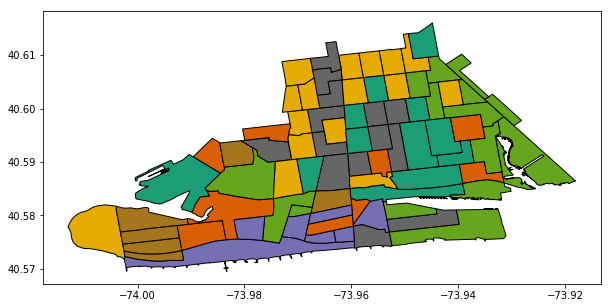

In [87]:
trt.plot(column = 'cluster', cmap = 'Dark2', edgecolor = 'black')

### Two tracts in the same cluster...

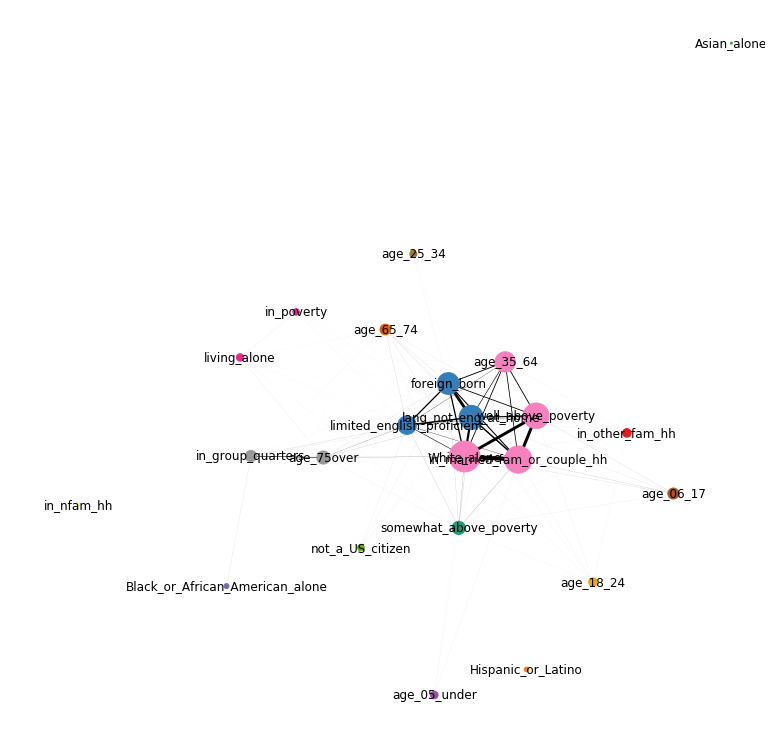

In [99]:
# Manhattan Beach Tract 616 (green, far southeast)
loc1 = 36047061600
np.random.seed(808)
popg.drawPopGraph(G = loc_g[loc1][0], part = loc_g[loc1][1], tcl = dat[dat.index == loc1])

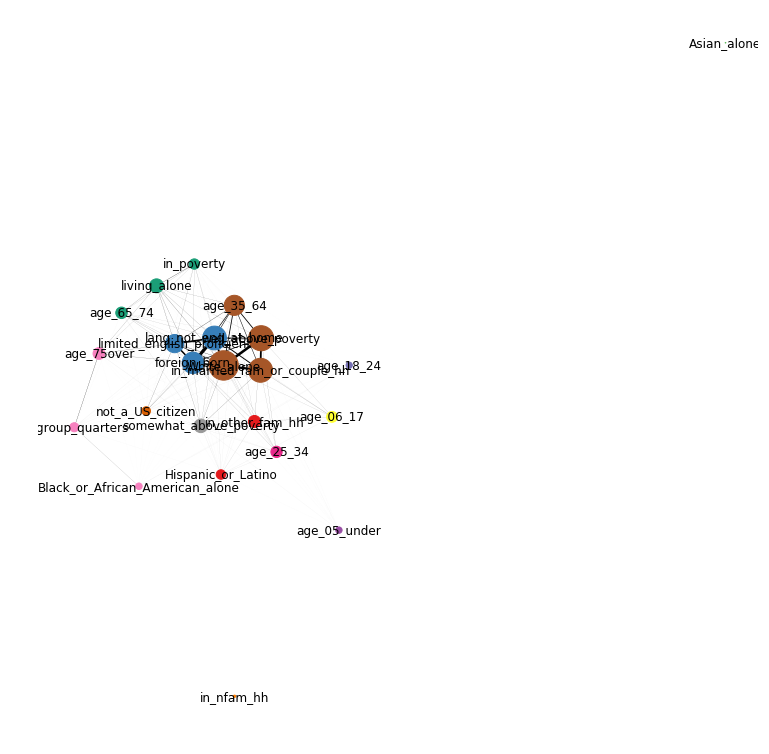

In [102]:
# Sheepshead Bay Tract 622 (green, right edge of plot)
loc2 = 36047062200
np.random.seed(808)
popg.drawPopGraph(G = loc_g[loc2][0], part = loc_g[loc2][1], tcl = dat[dat.index == loc2])

#### Check Graph Dissimilarity Metric

In [103]:
loc_key.index(str(loc1))

56

In [104]:
loc_key.index(str(loc2))

33

In [105]:
d[62,56]

0.46505282688698574

### Cluster profiles
WORK IN PROGRESS

In [109]:
p = pd.Series(loc_g[loc1][1])

In [112]:
pc = p.value_counts()
pc = pc[pc>1]

In [130]:
for i in pc.index:
    
    print p[p==i].index.tolist()
    print '\n'

['White_alone', 'age_35_64', 'in_married_fam_or_couple_hh', 'well_above_poverty']


['foreign_born', 'lang_not_eng_at_home', 'limited_english_proficient']


['in_poverty', 'living_alone']


['age_75over', 'in_group_quarters']


